In [1]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [2]:
from PIL import Image
from torchvision import transforms
input_image = Image.open('DUTS-TR\DUTS-TR-Image\ILSVRC2012_test_00004434.jpg')
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

In [3]:
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

img = r.save("DUTS-TR\Deeplab-Masked\Mask.png")

import matplotlib.pyplot as plt
plt.imshow(r)

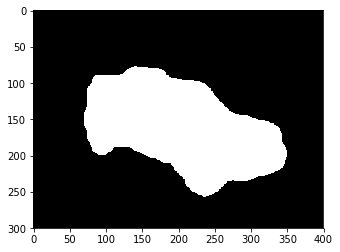

In [4]:
import cv2

imgA = cv2.imread('DUTS-TR\Deeplab-Masked\Mask.png')
imgA_gray = cv2.cvtColor(imgA, cv2.COLOR_RGB2GRAY)
ret, threshA = cv2.threshold(imgA_gray, 100, 255, cv2.THRESH_BINARY)
plt.imshow(threshA, cmap='gray')

Image Similarity: 94.7758%


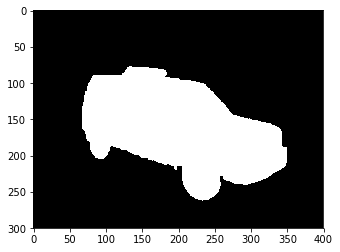

In [5]:
import os
import cv2
from os import listdir
from skimage.metrics import structural_similarity
directory = 'DUTS-TR\DUTS-TR-Mask'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        if (filename.endswith(".png")):
            imgB = cv2.imread(f)
            imgB_gray = cv2.cvtColor(imgB, cv2.COLOR_RGB2GRAY)
            ret, threshB = cv2.threshold(imgB_gray, 100, 255, cv2.THRESH_BINARY)
            
            hA,wA = threshA.shape
            hB,wB = threshB.shape
            
            if hA == hB and wA == wB:
                (score, diff) = structural_similarity(threshA, threshB, full=True)
                if score >= 0.9:
                    print("Image Similarity: {:.4f}%".format(score * 100))
                    plt.imshow(threshB, cmap='gray')